Complete notebook available at: https://github.com/ai4up/ufo-prediction/blob/main/demo/demo.ipynb

## Motivation

Building attributes such as building height, type, and construction year are not available for all buildings in EUBUCCO. However, for many prospective use cases of the dataset, such as energy modeling, the building attributes are of high importance. This notebook shows how the available building footprints can be used to estimate missing building attributes with supervised machine learning.

In [11]:
# -.-|m { input: false }

# standard libs
import os
import sys
import logging
import gc

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
import preprocessing as pp
import dataset

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb

In [12]:
# -.-|m { input: false }

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [3]:
# # When loading ufo data
# #DATA_DIR = '.'
# current_directory = os.getcwd()
# print(current_directory)

# path_data_NLD = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-NLD.pkl')
# path_data_FRA = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-FRA.pkl')
# path_data_ESP = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-ESP.pkl')
# print(path_data_NLD)
# df = pd.read_pickle(path_data_NLD)


/workspace
/workspace/workspace/ufo-prediction/demo/df-NLD.pkl


In [17]:
path_data_NLD = os.path.join(dataset.DATA_DIR, 'ufo-CNN_ALL.csv')
df = pd.read_csv(path_data_NLD, encoding='latin1')

In [18]:
df['age']

0       1936.0
1       1995.0
2       1993.0
3       1995.0
4       1987.0
         ...  
1770    1974.0
1771    1900.0
1772    1975.0
1773    1960.0
1774    1969.0
Name: age, Length: 1775, dtype: float64

In [19]:
df.drop(columns=['Predicted Class', 'Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6'])

,id,source_file,dist_to_closest_int,av_footprint_area_within_buffer_100,street_betweeness_global_max_within_buffer_500,av_elongation_within_buffer_500,geometry,std_building_footprint_city,block,blocks_2_to_4,...,buildings_within_buffer_100,street_betweeness_global_max_within_buffer_100,TouchesIndexes,street_based_block_av_phi_inter_buffer_500,total_length_street_city,total_buildings_footprint_city,Phi,street_based_block_std_area_inter_buffer_100,type,neighborhood
0,v0.1-NLD.1.11_1-24084,NL_lod12_2d_pand_2,42.461357,120.005361,0.067381,0.674941,POINT (4091690.389504442 3334685.331005264),424.396815,523f6838,3121.0,...,43.0,0.031989,[24084],0.410951,888712.235310,2.887787e+06,0.524328,9.063771e+05,NaN,89ef8324
1,v0.1-NLD.1.11_1-4079,NL_lod12_2d_pand_2,29.881210,126.434745,0.110367,0.654707,POINT (4099251.581367658 3337197.4897597586),424.396815,1b072026,3121.0,...,52.0,0.103494,[4079],0.436095,888712.235310,2.887787e+06,0.622589,2.046391e+06,NaN,d2b16a1a
2,v0.1-NLD.1.2_1-20562,NL_lod12_2d_pand_2,24.739313,115.901868,0.056551,0.641343,POINT (4092084.577978412 3328597.7539837556),386.512231,9c2946e5,5907.0,...,130.0,0.020112,"[579, 6323, 25965, 30337, 18033, 1302, 20562, ...",0.345612,708496.163500,3.936964e+06,0.476575,5.693715e+05,NaN,cb92baa3
3,v0.1-NLD.1.2_1-23823,NL_lod12_2d_pand_2,17.140888,56.486415,0.020837,0.672149,POINT (4092642.524445888 3329010.8895599474),386.512231,2c05c328,5907.0,...,176.0,0.015294,"[3451, 26080, 13532, 23823, 33759]",0.414110,708496.163500,3.936964e+06,0.528669,4.924259e+05,NaN,4108f866
4,v0.1-NLD.1.2_1-28237,NL_lod12_2d_pand_2,42.542218,52.763195,0.071705,0.637821,POINT (4090912.3071282906 3328745.0193218775),386.512231,22db0117,5907.0,...,142.0,0.058482,"[2504, 7260, 28237, 23375, 6710, 19478, 22671,...",0.349309,708496.163500,3.936964e+06,0.298096,1.440796e+06,NaN,08bd71fe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1770,v0.1-FRA.9.2.2.8_1-14889,BATIMENT-normandie,58.717310,123.342749,0.095610,0.616137,POINT (3676625.383531253 2917280.1740395837),518.091045,a69f03c3,2603.0,...,60.0,0.019231,"[14882, 14889, 14883]",0.390436,411652.822103,2.715634e+06,0.621938,5.471711e+04,residential,ab49433b
1771,v0.1-FRA.9.2.2.8_1-6602,BATIMENT-normandie,36.089642,177.885208,0.094716,0.583060,POINT (3675215.4822059567 2915510.5331037715),518.091045,8fc8dfb9,2603.0,...,68.0,0.087360,"[1143, 6602]",0.330693,411652.822103,2.715634e+06,0.497359,3.677560e+05,residential,aa7cee5c
1772,v0.1-FRA.9.3.4.5_1-1090,BATIMENT-normandie,158.295015,152.553640,0.101619,0.609940,POINT (3519865.480513634 2950185.1759083066),223.777076,4ff75afe,1482.0,...,19.0,0.072957,[1090],0.394060,647603.388207,1.297290e+06,0.590300,5.235398e+05,residential,8477944b
1773,v0.1-FRA.9.4.2.3_1-3905,BATIMENT-normandie,75.262391,228.969825,0.104087,0.625821,POINT (3587552.141770073 2898333.8640642613),574.200790,4ae5508c,987.0,...,33.0,0.095737,"[3904, 3906, 3905, 3907, 3908]",0.445677,209509.759359,1.108007e+06,0.562009,2.867146e+05,non-residential,eccc90af


In [20]:
df = df.rename(columns={'age': 'age_right'})


In [21]:
print(len(df))

1775


## Prediction

In [22]:
xgb_model_params = {'tree_method': 'hist', 
                    # 'n_estimators': 500
                    }
xgb_hyperparams = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

### Regression

2024-04-11 11:23:03,393 | INFO : Dataset length: 1775
2024-04-11 11:23:03,398 | INFO : Dataset allocated memory: 1 MB
2024-04-11 11:23:03,401 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-238ee9a9.abort.
2024-04-11 11:23:03,402 | INFO : Dataset standard deviation: 32.178497079475136
2024-04-11 11:23:03,403 | INFO : Dataset mean age: 1961.856338028169
2024-04-11 11:23:03,403 | INFO : Training dataset length: 1420
2024-04-11 11:23:03,404 | INFO : Test dataset length: 355
2024-04-11 11:23:03,415 | INFO : Test dataset standard deviation after preprocessing: 29.786836419589115
2024-04-11 11:23:03,416 | INFO : Test dataset mean age after preprocessing: 1963.0928143712574
2024-04-11 11:23:03,417 | INFO : Training dataset length after preprocessing: 1356
2024-04-11 11:23:03,417 | INFO : Test dataset length after preprocessing: 334
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, u

MAE: 21.20 y
RMSE: 26.39 y
R2: 0.2126
Energy need for heating in kWh/(m²a) R2: nan
Energy need for heating in kWh/(m²a) MAPE: nan


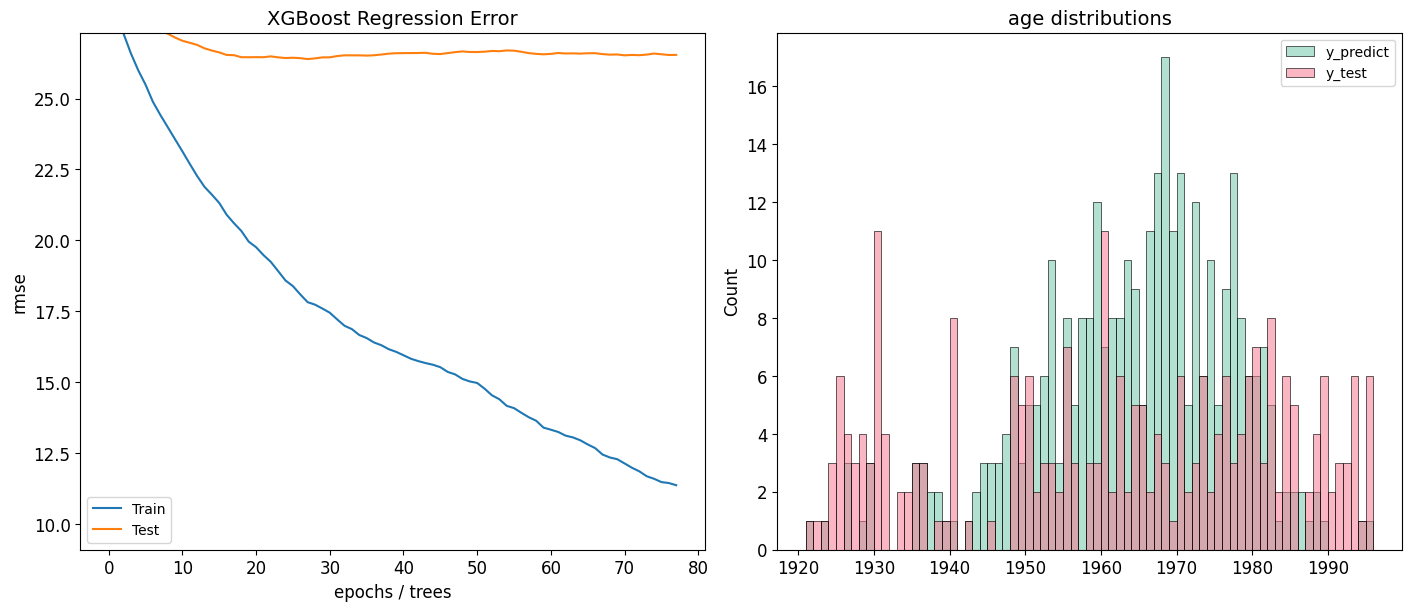

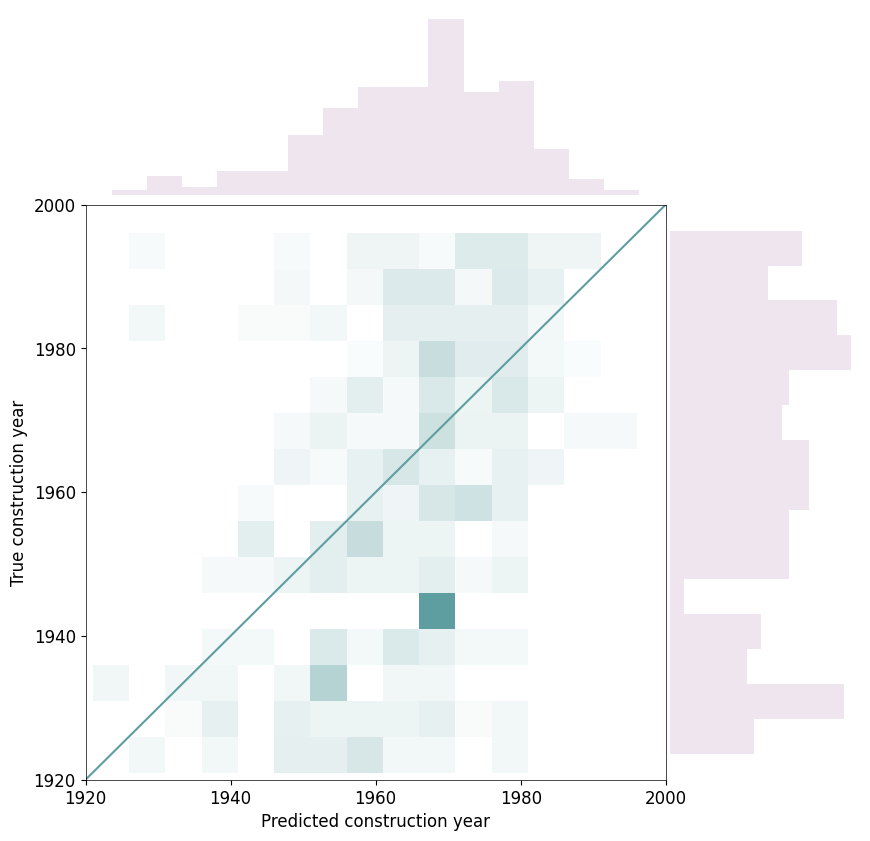

In [23]:
predictor = AgePredictor(
    model=XGBRegressor(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameters=xgb_hyperparams,
    # preprocessing_stages=[pp.remove_outliers, pp.categorical_to_int_byList, pp.convert_to_double_byList]
    preprocessing_stages=[pp.remove_outliers]
)

predictor.evaluate()


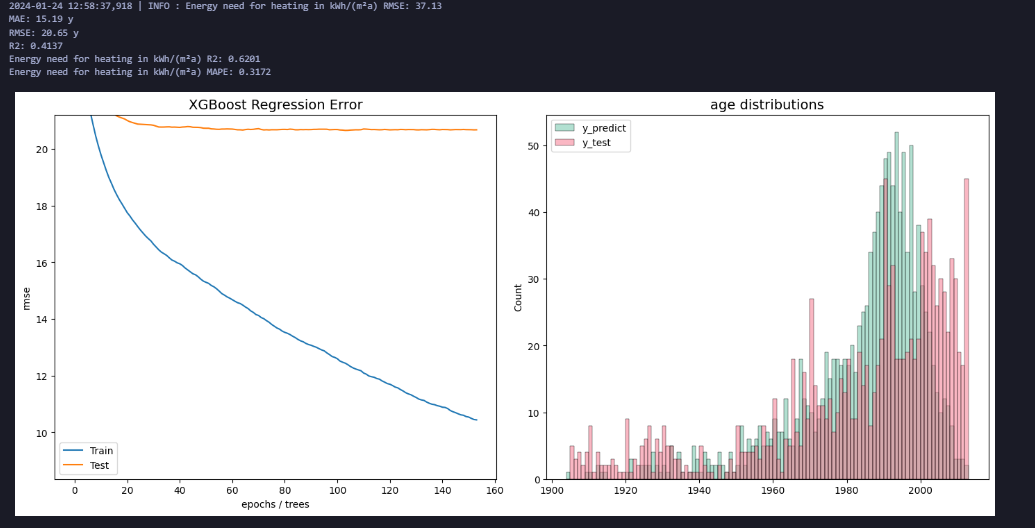
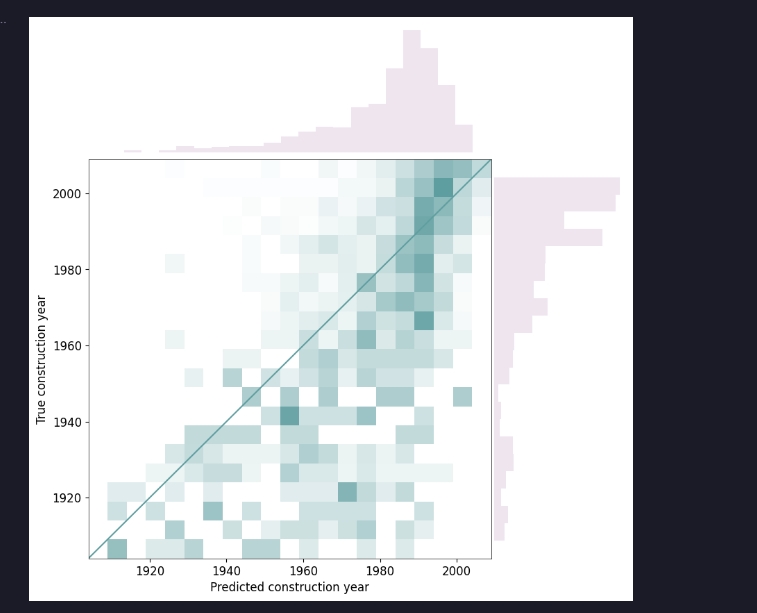

### Classification

2024-04-11 11:28:07,365 | INFO : Generated bins: [1900, 1965, 1975, 1992, 2006, 2015, 2022]
2024-04-11 11:28:07,366 | INFO : Generated bins with the following labels: ['1900-1964', '1965-1974', '1975-1991', '1992-2005', '2006-2014', '2015-2021']
2024-04-11 11:28:07,371 | INFO : Dataset length: 2180
2024-04-11 11:28:07,377 | INFO : Dataset allocated memory: 2 MB
2024-04-11 11:28:07,381 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-ead589d0.abort.
2024-04-11 11:28:07,382 | INFO : Training dataset length: 1744
2024-04-11 11:28:07,382 | INFO : Test dataset length: 436
2024-04-11 11:28:07,384 | INFO : Test cities: ['Alcubilla de Avellaneda' 'Le Mans' 'Stadskanaal' 'Almelo' 'Margraten'
 'Hellendoorn' 'San Esteban de Gormaz' 'Barcelona' 'Groningen' 'Sluis'
 'Boiro' 'Venlo' "Les Sables-d'Olonne" 'BescanÃ³' 'Diemen'
 "'s-Hertogenbosch" 'Sant Pere de Ribes' 'Ede' 'Madrid' 'Amsterdam'
 'Lesparre-MÃ©doc' 'Bordeaux' 'Nunspeet' 'Breuk

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Classification report:
               precision    recall  f1-score  support
1900-1964      0.732057  0.721698  0.726841      212
1965-1974      0.410256  0.340426  0.372093       47
1975-1991      0.341463  0.411765  0.373333       68
1992-2005      0.312500  0.384615  0.344828       52
2006-2014      0.450000  0.290323  0.352941       31
2015-2021      0.000000  0.000000  0.000000        5
accuracy       0.544578  0.544578  0.544578        0
macro avg      0.374380  0.358138  0.361673      415
weighted avg   0.549151  0.544578  0.544187      415
Cohen’s kappa: 0.3271
Matthews correlation coefficient (MCC): 0.3278


FixedFormatter should only be used together with FixedLocator


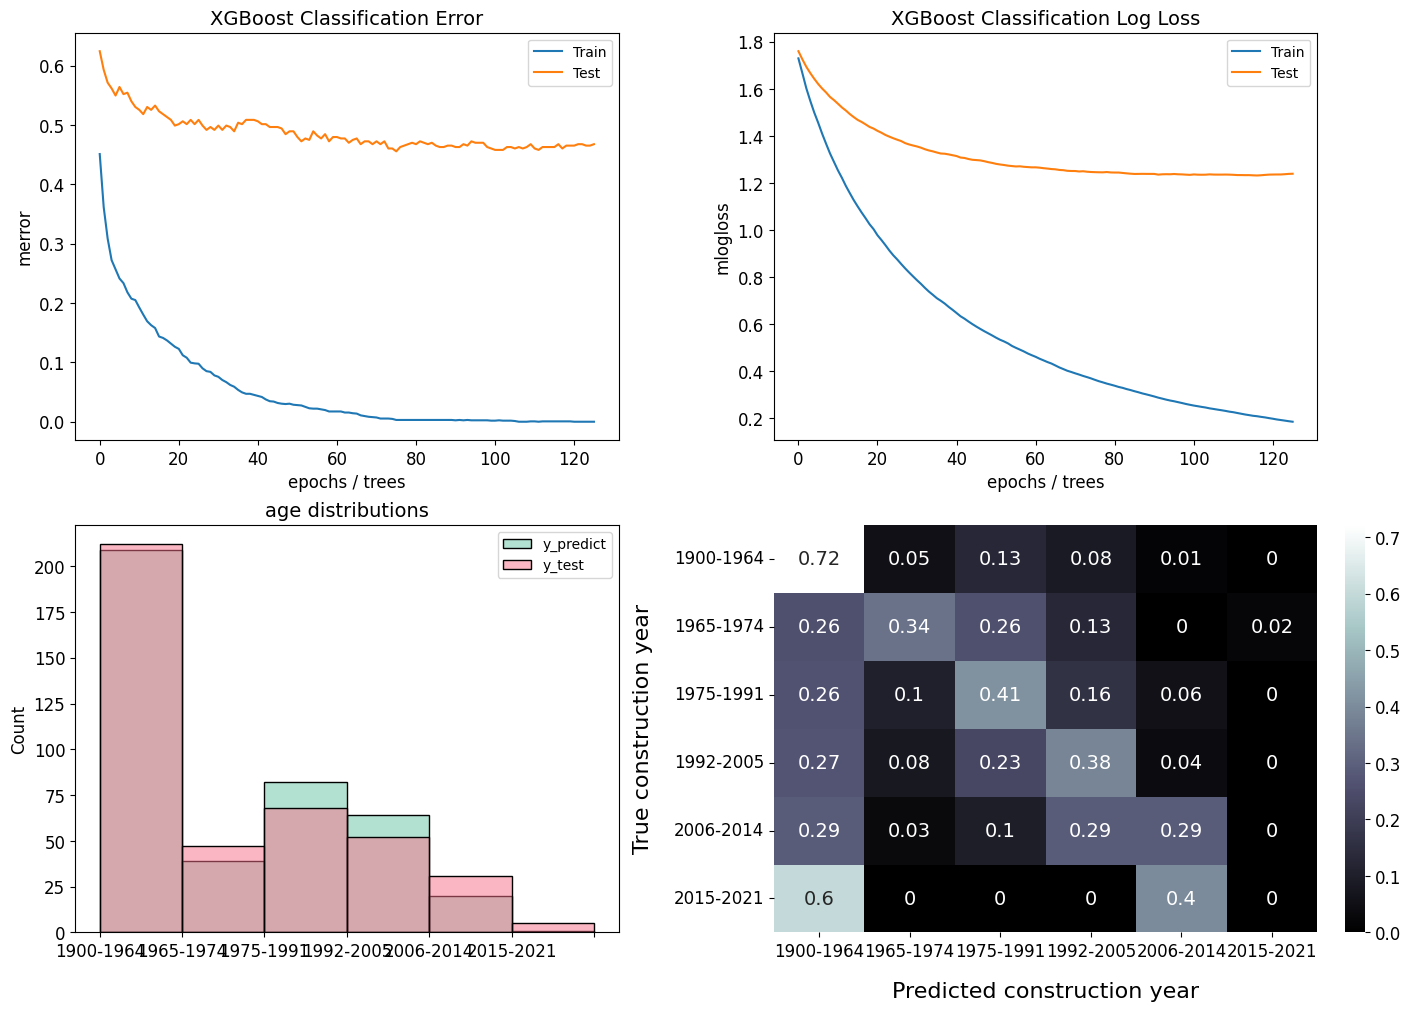

In [18]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = (1900, 2020, 10)

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    # bin_config=equally_sized_bins,
    bins=tabula_nl_bins,
)
classifier.evaluate()

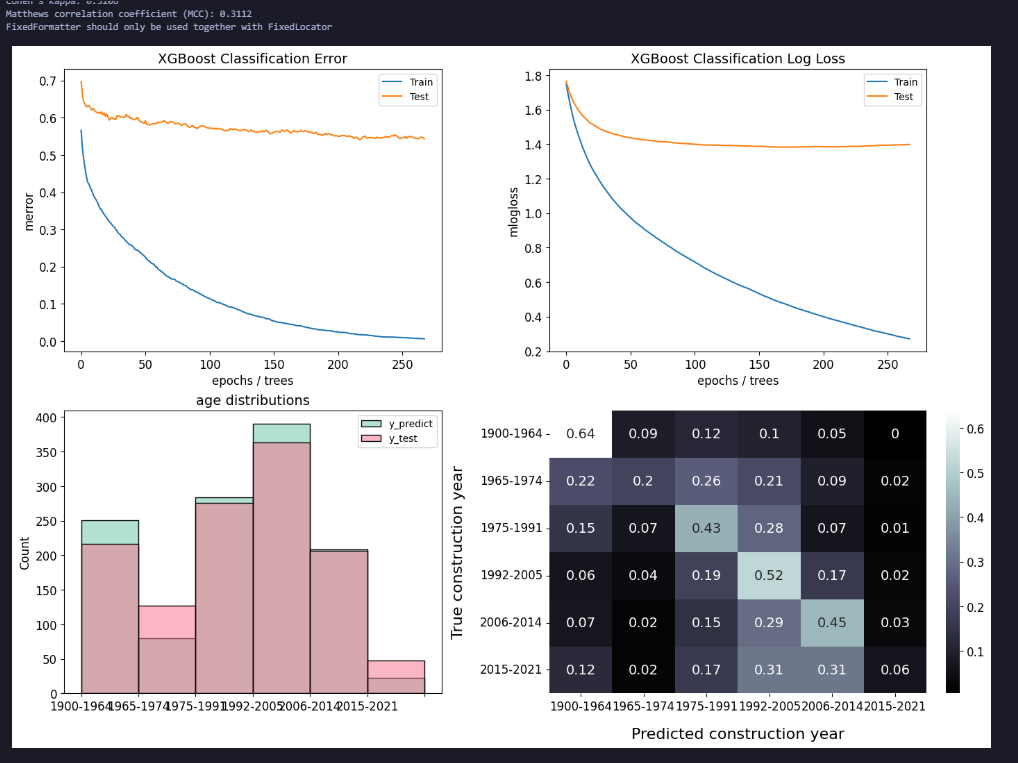

### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [21]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2024-01-17 14:50:47,195 | INFO : Starting experiment Spain_random-cv...


2024-01-17 14:53:18,314 | INFO : Dataset length: 4226188
2024-01-17 14:53:18,319 | INFO : Dataset allocated memory: 4385 MB
2024-01-17 14:53:20,237 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-33f2404e.abort.
2024-01-17 14:53:20,256 | INFO : Dataset standard deviation: 48.35942318636823
2024-01-17 14:53:20,263 | INFO : Dataset mean age: 1971.7313162594755
2024-01-17 14:53:20,264 | INFO : Training dataset length: 3380950
2024-01-17 14:53:20,264 | INFO : Test dataset length: 845238
2024-01-17 14:53:33,818 | INFO : Test dataset standard deviation after preprocessing: 25.909066171213233
2024-01-17 14:53:33,820 | INFO : Test dataset mean age after preprocessing: 1980.6306878251494
2024-01-17 14:53:33,821 | INFO : Training dataset length after preprocessing: 3058384
2024-01-17 14:53:33,821 | INFO : Test dataset length after preprocessing: 764264
`early_stopping_rounds` in `fit` method is deprecated for better compatibility

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/workspace/ufo-prediction/demo/df-FRA.pkl'

In [ ]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725


In [ ]:
del comparison, predictor, classifier, results, df, df_temp, df_temp2, df_dropped
gc.collect()